In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
!pip install openpyxl
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import LogNorm

# Functions

In [2]:
def apply_stepwise_coverage(loss, thresholds, payout_rates):
    covered = 0
    previous_thresh = 0
    
    for thresh, rate in zip(thresholds, payout_rates):
        if loss <= thresh:
            covered += (loss - previous_thresh) * rate
            break
        else:
            covered += (thresh - previous_thresh) * rate
            previous_thresh = thresh

    return covered

# Parameters

In [3]:
# model specifications
export = True
save = True
plot = False
pls_print = False

In [4]:
optimal_cluster = 'st_cluster_3_5_7'
risk_free = 0.0499 # LIBOR - 4.99 for yearly

In [5]:
test_case = "block"  #historic, block or random
climate = False
all_bond = False # all states pay for cat bond
fast_recovery = False # balance 0 thresholded

In [6]:
cat_bond = 6_500_000_000 # Could vary by region
spread_1 = 0.04 # base spread: 4, 6, 8
spread_2 = 0.02 # climate spread: 2, 10, 18 + 3.5 base
interest_rate = risk_free + spread_1 # need to integrate index based varying rate by year

if test_case == 'historic':
    simulations = 1
else:
    steps = 100
    block_size = 10
    simulations = 1000

In [7]:
# Reinsurance Rules
re_thres_vec = [7_000_000_000, 9_000_000_000, 11_000_000_000]
re_payout_vec = [0.120334, 0.258584, 0]
ils_thres_vec = [6_000_000_000, 7_000_000_000, 8_000_000_000, 9_000_000_000, 10_000_000_000, 11_000_000_000]
ils_payout_vec = [0.025, 0.10, 0.2625, 0.35, 0.2375, 0]

# Data Load

## Geospatial

In [8]:
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Load the shapefile for US rivers
rivers_shapefile_path = '../Local_Data/Rivers/rs16my07.shp'
gdf_rivers = gpd.read_file(rivers_shapefile_path)

# Load the shapefile for US urban areas
urban_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_ua10_500k.shp'
gdf_urban = gpd.read_file(urban_shapefile_path)

## NFIP Claims

In [9]:
clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")
clustered_claims['countyCode']=clustered_claims['countyCode'].apply(lambda x: str(x).zfill(5))
clustered_claims['stateCode']=clustered_claims['countyCode'].str[:2]

/tmp/ipykernel_645/224045918.py:1: DtypeWarning: Columns (7,25,32,35,38,42,51,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")


In [10]:
# Create the new field 'percentageDamageAmount'
clustered_claims['percentageBuildingDamageAmount'] = ((clustered_claims['buildingDamageAmount'] / clustered_claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
clustered_claims['totalClaimPaid'] = clustered_claims['amountPaidOnBuildingClaim'].fillna(0) + clustered_claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
clustered_claims = clustered_claims[clustered_claims['stateOwnedIndicator'] != True]

In [11]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 
#CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/CPI_by_Year_Month.csv") for homeowners insurance CPI

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
clustered_claims.loc[:, 'yearOfLoss'] = clustered_claims['dateOfLoss'].dt.year

# Merge clustered_claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(clustered_claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

clustered_claims = claims_merged

/tmp/ipykernel_645/1551299827.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_645/1551299827.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_645/1551299827.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an in

In [12]:
# Katrina
katrina = 4
katrina_numbers =[4520, 1707, 1561, 1246, 2187, 1481] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: katrina if x in katrina_numbers else x
)

# Sandy
sandy = 87
sandy_numbers =[1603, 1507, 1252] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: sandy if x in sandy_numbers else x
)

# Harvey
harvey = 327
harvey_numbers =[3430, 5719, 5614, 5712, 5678, 5611, 1456, 1736] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: harvey if x in harvey_numbers else x
)

# Ian
ian = 166
ian_numbers =[3907, 4050] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ian if x in ian_numbers else x
)

# ike
ike = 8
ike_numbers =[222, 1559, 1419] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ike if x in ike_numbers else x
)

# la_2016
la_2016 = 295
la_2016_numbers =[3731, 2086, 2053, 3617, 3557] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: la_2016 if x in la_2016_numbers else x
)

# ivan
ivan = 6
ivan_numbers =[159, 364, 4003, 4459, 164, 143, 434]

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: ivan if x in ivan_numbers else x
)

# helene
helene = 190
helene_numbers =[195] 

clustered_claims[optimal_cluster] = clustered_claims[optimal_cluster].apply(
    lambda x: helene if x in helene_numbers else x
)

In [13]:
# Cluster numbers and names
cluster_num = [4, 87, 327, 166, 8, 295, 6, 190]
cluster_names = ["Katrina", "Sandy", "Harvey", "Ian", "Ike", "LA 2016 Floods", "Ivan", "Helene"]

## Nino 3.4

In [14]:
nino34_path = '../Local_Data/Climatological_Index/nino34.long.anom.hadisst.csv'
nino34 = pd.read_csv(
    nino34_path,
    skiprows=1,
    header=None,  # No header in the file
    names=["datetime", "ANOM"],  # Assign column names
    parse_dates=["datetime"]  # Parse first column as datetime
)
# Drop last 12 rows
nino34 = nino34.iloc[:-12]

# Extract year
nino34["YR"] = nino34["datetime"].dt.year

In [15]:
# Ensure ANOM is numeric
nino34['ANOM'] = pd.to_numeric(nino34['ANOM'], errors='coerce')

# Group by year
grouped = nino34.groupby('YR')

# Compute nino and nina
nino = grouped.apply(lambda g: g[g['ANOM'] > 0]['ANOM'].sum())
nina = grouped.apply(lambda g: g[g['ANOM'] < 0]['ANOM'].sum())

# Combine into a new DataFrame
enso_ann_index = pd.DataFrame({
    'YR': nino.index,
    'nino': nino.values,
    'nina': nina.values
}).reset_index(drop=True)

# Normalize nina by its minimum (note: nina is negative, so this preserves relative magnitude)
enso_ann_index['nina_norm'] = enso_ann_index['nina'] / enso_ann_index['nina'].min()

# Normalize nino by its maximum
enso_ann_index['nino_norm'] = enso_ann_index['nino'] / enso_ann_index['nino'].max()

/tmp/ipykernel_645/3208843501.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nino = grouped.apply(lambda g: g[g['ANOM'] > 0]['ANOM'].sum())
/tmp/ipykernel_645/3208843501.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nina = grouped.apply(lambda g: g[g['ANOM'] < 0]['ANOM'].sum())


## NFIP RR2 Premiums

In [16]:
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
    'Policies in Force': 'sum',
    'Total Coverage': 'sum',
    'Total Written Premium + FPF': 'sum',
    'Total Annual Payment': 'sum'
}).reset_index()

In [17]:
# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

In [18]:
state_abbrev_dict = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA',
    '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL',
    '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN',
    '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS',
    '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND',
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT',
    '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI',
    '56': 'WY'
}

In [19]:
state_claims = pd.read_csv('../Local_Data/NFIP_Data/All_Claims_by_Year.csv')
state_claims = state_claims.groupby("State").aggregate({'Total Claim Dollars Paid':'mean','Total Paid Claims':'mean'}).reset_index()
state_claims['State'] = state_claims['State'].str.upper()
state_claims = state_claims.merge(state_df, left_on='State', right_on='State Name', how='left')
state_policies = aggregated_risk_policies.groupby("State").aggregate({
    'Policies in Force':'sum',
    'Total Coverage':'sum',
    'Total Written Premium + FPF':'sum',
    'Total Annual Payment':'sum'}).reset_index()
state_merged = state_claims.merge(state_policies, left_on='State', right_on='State', how='left')
state_merged['meanLoss'] = state_merged['Total Written Premium + FPF']-state_merged['Total Claim Dollars Paid']

# Merge the aggregated data with the shapefile
gdf_states = gdf_states.merge(state_merged, left_on='GEOID', right_on='State FIPS', how='left')

In [20]:
# Step 1: Compute total premium
total_premium = gdf_states["Total Written Premium + FPF"].sum()

# Step 2: Create a new column for percentage of total
gdf_states["Contribution %"] = 100 * gdf_states["Total Written Premium + FPF"] / total_premium

# Step 3: Create a new column for value of the pool
gdf_states["Benefit"] = 100 / gdf_states["Contribution %"]
gdf_states["OG_Benefit"] = gdf_states["Benefit"]
og_gain_balance = np.min(gdf_states["Benefit"])

# Step 4: Create a new column for the withdrawal max
gdf_states["Withdrawal_threshold"] = gdf_states["Total Written Premium + FPF"]*og_gain_balance
gdf_states["OG_Withdrawal_threshold"] = gdf_states["Withdrawal_threshold"]

# Remove AL and HI for simulation
gdf_states = gdf_states[~gdf_states['State'].isin(['ALASKA', 'HAWAII'])]

# Main

In [21]:
# Define Hurricanes
hurricanes = [4, 87, 327, 166, 8, 6, 190] # Katrina, Sandy, Harvey, Ian, Ike, Ivan, Helene
clustered_claims["is_TS"] = clustered_claims[optimal_cluster].isin(hurricanes)

In [22]:
# Initialization
years_arr = np.array(sorted(clustered_claims["dateOfLoss"].dt.year.unique()), dtype=int)
min_year, max_year = years_arr.min(), years_arr.max()

# For block bootstrap, keep the horizon equal to the span you're resampling over
steps = len(years_arr) if test_case == "historic" else steps

# Global containers
cluster_state_output = []     # Cluster-level payouts per state-year
state_balance_output = []     # State-level financial summaries
final_balance_sheets = []     # End-of-simulation state balances

# Initialize transition tracker and sign memory
balance_transitions = []
previous_positive = {}  # Keyed by (simulation, state): True/False

for n in range(simulations):
    print(f'\nSimulation {n + 1}/{simulations}')

    # Year sampling
    if test_case == "random":
        sampled_years = np.random.choice(years_arr, size=steps, replace=True).tolist()
        synthetic_years = list(range(min_year, min_year + steps))

    elif test_case == "block":
        n_blocks = int(np.ceil(steps / block_size))
        
        # Get all years in historical record
        years = sorted(clustered_claims["dateOfLoss"].dt.year.unique())
        min_year, max_year = min(years), max(years)
        
        # All valid block start years
        start_years = list(range(min_year, max_year - block_size + 2))
        
        # Sample block start years with replacement
        sampled_starts = np.random.choice(start_years, size=n_blocks, replace=True)
        
        # Build sampled (historical) years from the blocks
        sampled_years = []
        for start in sampled_starts:
            block = list(range(start, start + block_size))
            sampled_years.extend(block)
        
        # Truncate to exact desired length
        sampled_years = sampled_years[:steps]
        
        # Synthetic timeline (same length as steps, starting from 1978 or other baseline)
        synthetic_years = list(range(min_year, min_year + steps))

    else:
        sampled_years = years_arr.tolist()
        synthetic_years = years_arr.tolist()

    # Initialize balance sheet for this simulation
    balance_sheet = gdf_states.copy()
    balance_sheet["STATEFP"] = balance_sheet["STATEFP"].astype(str)
    balance_sheet["contribution"] = 0
    balance_sheet["nfip_balance"] = 0

    for i in range(steps):
        sample_year = sampled_years[i]
        display_year = synthetic_years[i]

        if pls_print:
            print(f'  Processing year {sample_year}')

        # Subset claims for current year
        year_claims = clustered_claims[clustered_claims["year"] == sample_year]

        # Compute state-cluster claims
        state_cluster_damage = (
            year_claims
            .groupby(["stateCode", optimal_cluster])["adjustedClaim"]
            .sum()
            .reset_index()
        )
        state_cluster_damage["stateCode"] = state_cluster_damage["stateCode"].astype(str)

        # Merge with base balance sheet
        temp = balance_sheet.merge(
            state_cluster_damage,
            how="left",
            left_on="STATEFP",
            right_on="stateCode"
        )
        temp["adjustedClaim"] = temp["adjustedClaim"].fillna(0)

        # Initialize reinsurance and ILS columns
        temp["re_covered"] = 0.0
        temp["ils_covered"] = 0.0
        temp["total_covered"] = 0.0

        # Compute total loss per cluster and find high-loss clusters
        cluster_damage = (
            year_claims
            .groupby(optimal_cluster)["adjustedClaim"]
            .sum()
            .reset_index()
            .merge(
                clustered_claims[[optimal_cluster, "is_TS"]].drop_duplicates(),
                on=optimal_cluster,
                how="left"
            )
        )
        min_thresh = min(re_thres_vec[0], ils_thres_vec[0])
        high_loss_clusters = cluster_damage[cluster_damage["adjustedClaim"] > min_thresh]

        # Allocate coverage only to affected state-cluster pairs
        for _, row in high_loss_clusters.iterrows():
            cluster = row[optimal_cluster]
            total_loss = row["adjustedClaim"]
            is_ts = row["is_TS"]

            # State-wise breakdown of this cluster
            state_breakdown = (
                year_claims[year_claims[optimal_cluster] == cluster]
                .groupby("stateCode")["adjustedClaim"]
                .sum()
                .reset_index()
            )
            state_breakdown["proportion"] = state_breakdown["adjustedClaim"] / total_loss

            re_covered = apply_stepwise_coverage(total_loss, re_thres_vec, re_payout_vec)
            ils_covered = apply_stepwise_coverage(total_loss, ils_thres_vec, ils_payout_vec) if is_ts else 0
            total_cluster_covered = re_covered + ils_covered

            # In-place update of temp for each state in the cluster
            for _, s_row in state_breakdown.iterrows():
                state = s_row["stateCode"]
                prop = s_row["proportion"]

                mask = (temp["STATEFP"] == state) & (temp[optimal_cluster] == cluster)
                temp.loc[mask, "re_covered"] += prop * re_covered
                temp.loc[mask, "ils_covered"] += prop * ils_covered
                temp.loc[mask, "total_covered"] += prop * total_cluster_covered

        # Annotate metadata
        temp["year"] = display_year
        temp["simulation"] = n

        # Store cluster-level results
        cluster_state_output.append(
            temp[[
                "STATEFP", "stateCode", optimal_cluster, "adjustedClaim",
                "re_covered", "ils_covered", "total_covered",
                "year", "simulation"
            ]]
        )

        # --- State-level financial tracking ---
        state_summary = (
            temp.groupby("STATEFP")[["adjustedClaim", "re_covered", "ils_covered", "total_covered"]]
            .sum()
            .reset_index()
        )

        # Add premiums and calculate contributions
        state_summary = state_summary.merge(
            balance_sheet[["STATEFP", "Total Written Premium + FPF"]],
            on="STATEFP", how="left"
        ).rename(columns={"Total Written Premium + FPF": "premium"}).fillna({"premium": 0})

        state_summary["nfip_payout"] = state_summary["adjustedClaim"] - state_summary["total_covered"]
        state_summary["contribution"] = state_summary["premium"] - state_summary["nfip_payout"]
        state_summary["year"] = display_year
        state_summary["simulation"] = n
        state_summary = state_summary.merge(balance_sheet[["STATEFP", "nfip_balance"]], on="STATEFP", how="left")

        # Merge contributions, ensuring all states retained
        balance_sheet = balance_sheet.merge(
            state_summary[["STATEFP", "contribution"]],
            on="STATEFP", how="left",
            suffixes=('', '_new')
        )
        
        # Safely fill and update contribution column
        if "contribution_new" in balance_sheet.columns:
            balance_sheet["contribution"] = balance_sheet["contribution_new"].fillna(0.0)
            balance_sheet = balance_sheet.drop(columns=["contribution_new"])
        else:
            balance_sheet["contribution"] = 0.0
        
        # Update running balance
        balance_sheet["nfip_balance"] += balance_sheet["contribution"]

        # Track balance transitions from positive to negative
        for _, row in balance_sheet.iterrows():
            state = row["STATEFP"]
            sim_key = (n, state)
            current_balance = row["nfip_balance"]
            was_positive = previous_positive.get(sim_key, True)  # Default to True at start
        
            # Check for transition from positive to negative
            if was_positive and current_balance < 0:
                # Find highest-loss cluster for this state-year
                state_clusters = temp[temp["STATEFP"] == state]
                if not state_clusters.empty:
                    max_row = state_clusters.loc[state_clusters["adjustedClaim"].idxmax()]
                    balance_transitions.append({
                        "simulation": n,
                        "year": display_year,
                        "STATEFP": state,
                        "top_cluster": max_row[optimal_cluster],
                        "cluster_loss": max_row["adjustedClaim"]
                    })
        
            # Update current balance sign
            previous_positive[sim_key] = current_balance >= 0

        # Store state-year summary
        state_balance_output.append(state_summary)

    # Store final balance sheet for this simulation
    balance_sheet["simulation"] = n
    final_balance_sheets.append(balance_sheet.copy())


Simulation 1/1000

Simulation 2/1000

Simulation 3/1000

Simulation 4/1000

Simulation 5/1000

Simulation 6/1000

Simulation 7/1000

Simulation 8/1000

Simulation 9/1000

Simulation 10/1000

Simulation 11/1000

Simulation 12/1000

Simulation 13/1000

Simulation 14/1000

Simulation 15/1000

Simulation 16/1000

Simulation 17/1000

Simulation 18/1000

Simulation 19/1000

Simulation 20/1000

Simulation 21/1000

Simulation 22/1000

Simulation 23/1000

Simulation 24/1000

Simulation 25/1000

Simulation 26/1000

Simulation 27/1000

Simulation 28/1000

Simulation 29/1000

Simulation 30/1000

Simulation 31/1000

Simulation 32/1000

Simulation 33/1000

Simulation 34/1000

Simulation 35/1000

Simulation 36/1000

Simulation 37/1000

Simulation 38/1000

Simulation 39/1000

Simulation 40/1000

Simulation 41/1000

Simulation 42/1000

Simulation 43/1000

Simulation 44/1000

Simulation 45/1000

Simulation 46/1000

Simulation 47/1000

Simulation 48/1000

Simulation 49/1000

Simulation 50/1000

Simulati

In [23]:
# Compile all outputs
cluster_state_df = pd.concat(cluster_state_output, ignore_index=True)
state_balance_df = pd.concat(state_balance_output, ignore_index=True)
final_balances_df = pd.concat(final_balance_sheets, ignore_index=True)
balance_transition_df = pd.DataFrame(balance_transitions)

if export:
    cluster_state_df.to_csv(f'Results/cluster_state_{test_case}.csv')
    state_balance_df.to_csv(f'Results/state_balance_{test_case}.csv')
    final_balances_df.to_csv(f'Results/final_balances_{test_case}.csv')
    balance_transition_df.to_csv(f'Results/balance_transition_{test_case}.csv')

# Evaluation

## National Pool

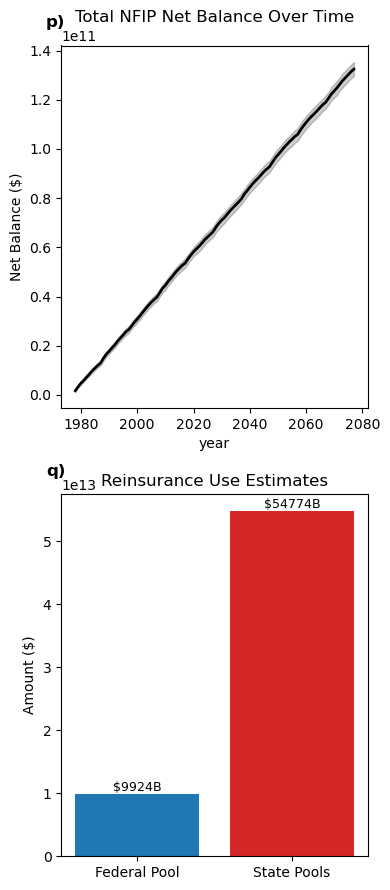

In [24]:
# Ensure balance data is compiled
state_balance_df = pd.concat(state_balance_output, ignore_index=True)
final_balances_df = pd.concat(final_balance_sheets, ignore_index=True)

# ─────────────────────────────
# 1) Net NFIP Balance Time Series (all states summed)
# ─────────────────────────────
time_series_df = (
    state_balance_df
    .groupby(["simulation", "year"])["contribution"]
    .sum()
    .groupby(level=0).cumsum()
    .reset_index(name="total_balance")
)

# ─────────────────────────────
# 2) Bar chart: Final Net Negative Balance vs Reinsurance
# ─────────────────────────────
final_df = final_balances_df.copy()

# Filter to negative balances
neg_df = final_df[final_df["nfip_balance"] < 0]

# Aggregate reinsurance used and negative balances across all states
summary = pd.DataFrame({
    "Simulation": list(range(len(final_balance_sheets))),
    "Total_Reinsurance_Used": [
        cluster_state_df.query(f"simulation == {i}")["re_covered"].sum()
        for i in range(len(final_balance_sheets))
    ],
    "Total_Negative_Balance": [
        neg_df.query(f"simulation == {i}")["nfip_balance"].sum()
        for i in range(len(final_balance_sheets))
    ]
})

# ─────────────────────────────
# Plotting
# ─────────────────────────────
fig, axs = plt.subplots(2, 1, figsize=(4, 9), sharex=False)
panel_labels = ['p)', 'q)']
label_offset = (-0.05, 1.05)

# --- Panel a: Time Series of Total Balance ---
sns.lineplot(
    data=time_series_df,
    x="year", y="total_balance", legend=False, ax=axs[0], color='black',
    lw=2
)
axs[0].set_title("Total NFIP Net Balance Over Time")
axs[0].set_ylabel("Net Balance ($)")
axs[0].text(label_offset[0], label_offset[1], panel_labels[0], transform=axs[0].transAxes, fontsize=12, fontweight='bold')

# --- Panel b: Summary Bar Chart (Aggregated) ---
bar_labels = ["Federal Pool", "State Pools"]
bar_values = [
    summary["Total_Reinsurance_Used"].sum(),
    summary["Total_Negative_Balance"].abs().sum()
]

axs[1].bar(bar_labels, bar_values, color=["tab:blue", "tab:red"])
axs[1].set_title("Reinsurance Use Estimates")
axs[1].set_ylabel("Amount ($)")
axs[1].set_xlabel("")  # Optional: keep clean

# Optional: add value labels on top of bars
for i, value in enumerate(bar_values):
    rounded = round(value / 1e9)
    axs[1].text(i, value, f"${rounded}B", ha='center', va='bottom', fontsize=9)
# Panel label
axs[1].text(label_offset[0], label_offset[1], panel_labels[1], transform=axs[1].transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/NFIP_Summary_Facets_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Extreme Loss vs Underpricing Risk

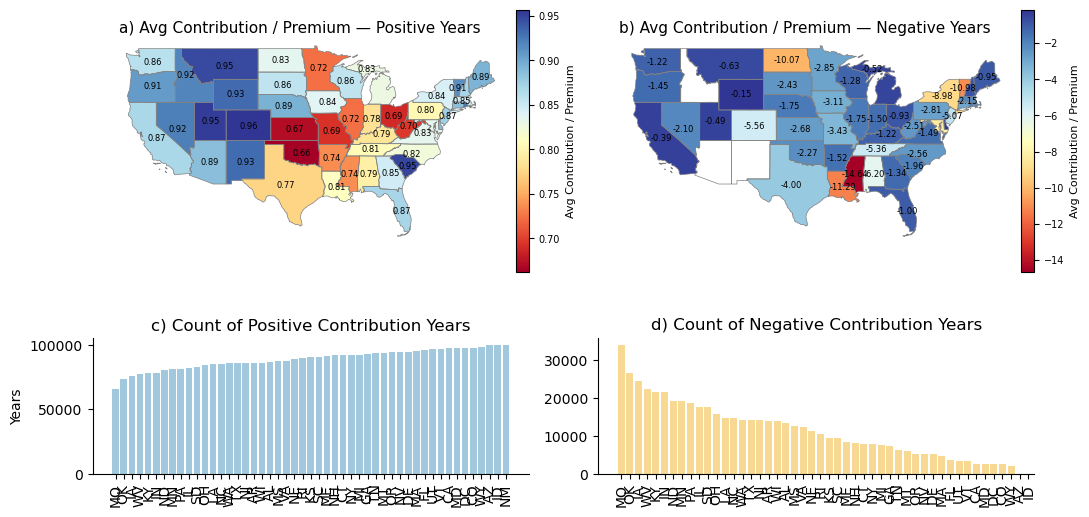

In [25]:
# ── Step 1: Create category flags ──
state_balance_df["is_positive"] = state_balance_df["contribution"] > 0
state_balance_df["is_negative"] = state_balance_df["contribution"] < 0
state_balance_df["contribution_ratio"] = state_balance_df["contribution"] / state_balance_df["premium"]
state_balance_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ── Step 2: Group by STATEFP and calculate averages ──
def average_ratio(df, flag_col, flag_val, label):
    return (
        df[df[flag_col] == flag_val]
        .groupby("STATEFP")["contribution_ratio"]
        .mean()
        .reset_index()
        .rename(columns={"contribution_ratio": label})
    )

avg_positive = average_ratio(state_balance_df, "is_positive", True, "Avg_Pos")
avg_negative = average_ratio(state_balance_df, "is_negative", True, "Avg_Neg")

# ── Step 3: Count years and join STUSPS ──
state_lookup = gdf_states[["STATEFP", "STUSPS"]]

count_positive = (
    state_balance_df[state_balance_df["is_positive"]]
    .groupby("STATEFP")
    .size()
    .reset_index(name="Positive_Years")
    .merge(state_lookup, on="STATEFP")
)

count_negative = (
    state_balance_df[state_balance_df["is_negative"]]
    .groupby("STATEFP")
    .size()
    .reset_index(name="Negative_Years")
    .merge(state_lookup, on="STATEFP")
)

# Match ordering for both plots
plot_order = count_positive["STUSPS"].tolist()
count_negative = count_negative[count_negative["STUSPS"].isin(plot_order)]
count_negative = count_negative.set_index("STUSPS").reindex(plot_order).reset_index()

# Safely reindex both to same order
sort_order = count_positive.sort_values("Positive_Years")["STUSPS"]

# Reindex both with sorted STUSPS
count_positive = count_positive.set_index("STUSPS").reindex(sort_order).reset_index()
count_negative = count_negative.set_index("STUSPS").reindex(sort_order).reset_index()

# ── Step 4: Merge choropleth data into GeoDataFrame ──
gdf_plot = gdf_states.copy()
for df in [avg_positive, avg_negative]:
    gdf_plot = gdf_plot.merge(df, on="STATEFP", how="left")

# ── Step 5: Plot configuration ──
fig = plt.figure(figsize=(11, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])  # top taller, bottom shorter

axs = [
    fig.add_subplot(gs[0, 0]),  # a) Map
    fig.add_subplot(gs[0, 1]),  # b) Map
    fig.add_subplot(gs[1, 0]),  # c) Bar
    fig.add_subplot(gs[1, 1]),  # d) Bar
]

extent = [-130, -65, 24, 50]
x_min, x_max, y_min, y_max = extent
skip_labels = {"DC", "RI", "CT", "DE", "MD", "NH"}
cmap = "RdYlBu"

# ── Panels a & b: Choropleths ──
choropleth_configs = [
    ("Avg_Pos", "a) Avg Contribution / Premium — Positive Years"),
    ("Avg_Neg", "b) Avg Contribution / Premium — Negative Years"),
]

for ax, (col, title) in zip(axs[:2], choropleth_configs):
    vmin = gdf_plot[col].min()
    vmax = gdf_plot[col].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    gdf_plot.plot(column=col, cmap=cmap, linewidth=0.1, ax=ax, norm=norm, legend=False)
    gdf_plot.boundary.plot(ax=ax, color="grey", linewidth=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("off")
    ax.set_title(title, fontsize=11)

    for _, row in gdf_plot.iterrows():
        abbr = row["STUSPS"]
        rep_point = row.geometry.representative_point()
        x, y = rep_point.x, rep_point.y
        val = row[col]
        if abbr in skip_labels or np.isnan(val):
            continue
        ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=6, color='black')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("Avg Contribution / Premium", fontsize=8)
    cbar.ax.tick_params(labelsize=7)

# ── Panels c & d: Vertical bar charts with shared x-axis ──
axs[2].bar(count_positive["STUSPS"], count_positive["Positive_Years"], color="#A1C8DD")
axs[2].set_title("c) Count of Positive Contribution Years")
axs[2].tick_params(axis='x', rotation=90)
if test_case == 'historic':
    axs[2].set_ylim([0,47])
axs[2].spines[['top', 'right']].set_visible(False)
axs[2].set_ylabel("Years")

axs[3].bar(count_negative["STUSPS"], count_negative["Negative_Years"], color="#F8D994")
axs[3].set_title("d) Count of Negative Contribution Years")
axs[3].tick_params(axis='x', rotation=90)
axs[3].spines[['top', 'right']].set_visible(False)
if test_case == 'historic':
    axs[3].set_ylim([0,47])


# ── Final layout ──
plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/Contribution_MapsAndBars_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Timeseries of State Pools

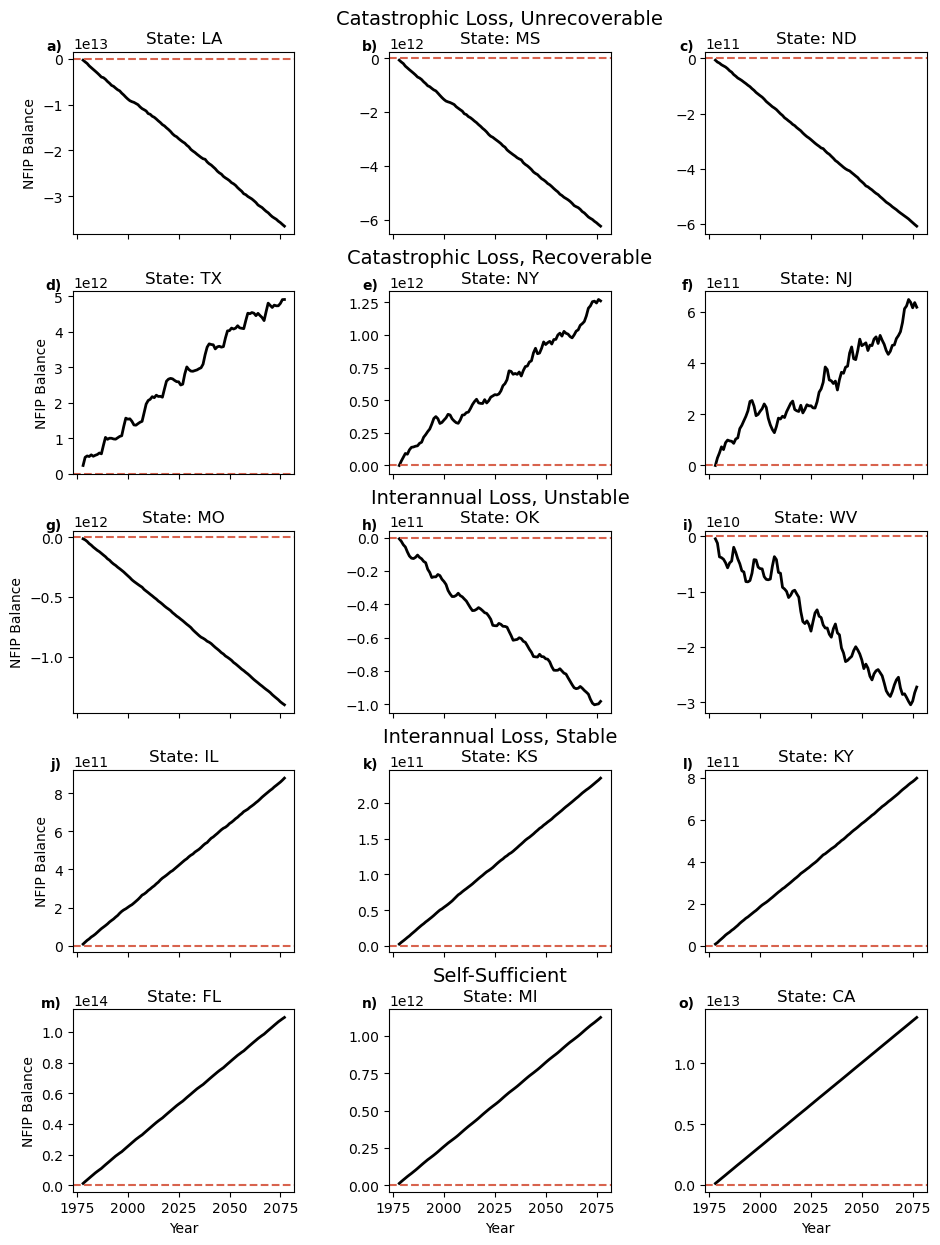

In [26]:
# Abbreviation mapping (if needed)
state_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO',
    '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY',
    '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD',
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

# Selected state abbreviations
selected_states = ['LA', 'MS', 'ND', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'IL', 'KS', 'KY', 'FL', 'MI', 'CA']

# Build DataFrame from state_balance_output
state_year_df = pd.concat(state_balance_output, ignore_index=True)

# Add abbreviation column
state_year_df["State"] = state_year_df["STATEFP"].map(state_abbrev)

# Filter to selected states
filtered_df = state_year_df[state_year_df["State"].isin(selected_states)].copy()

# Group by state and year across simulations, compute mean balance
state_balance_by_year = (
    filtered_df
    .groupby(["State", "year"])["contribution"]
    .sum()
    .groupby(level=0).cumsum()  # Cumulative NFIP balance by year
    .reset_index()
    .rename(columns={"contribution": "nfip_balance"})
)

# Prepare subplots
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]
    df_sub = state_balance_by_year[state_balance_by_year["State"] == state]
    ax.plot(df_sub["year"], df_sub["nfip_balance"], color='black', linewidth=2)
    ax.axhline(0, color='#D8634E', linestyle='--')
    ax.set_title(f"State: {state}")

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.05, 1.07, panel_label,
            transform=ax.transAxes,
            fontsize=10,
            fontweight='bold',
            va='top',
            ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    if row_idx == n_rows - 1:
        ax.set_xlabel("Year")
    else:
        ax.set_xlabel("")

    if col_idx == 0:
        ax.set_ylabel("NFIP Balance")
    else:
        ax.set_ylabel("")

# Optional row titles (adjust as needed)
row_titles = [
    "Catastrophic Loss, Unrecoverable",
    "Catastrophic Loss, Recoverable",
    "Interannual Loss, Unstable",
    "Interannual Loss, Stable",
    "Self-Sufficient"
]

for row_idx in range(n_rows):
    mid_col_idx = row_idx * n_cols + 1
    if mid_col_idx < len(axes):
        ax = axes[mid_col_idx]
        ax.annotate(
            row_titles[row_idx],
            xy=(0.5, 1.13),
            xycoords='axes fraction',
            ha='center',
            va='bottom',
            fontsize=14
        )

plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0.05, 0, 1, 1])
if save:
    plt.savefig(f"Plots/New/Balance_Timeseries_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Debt Accumulation by State

/tmp/ipykernel_645/2130681533.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral", len(states))


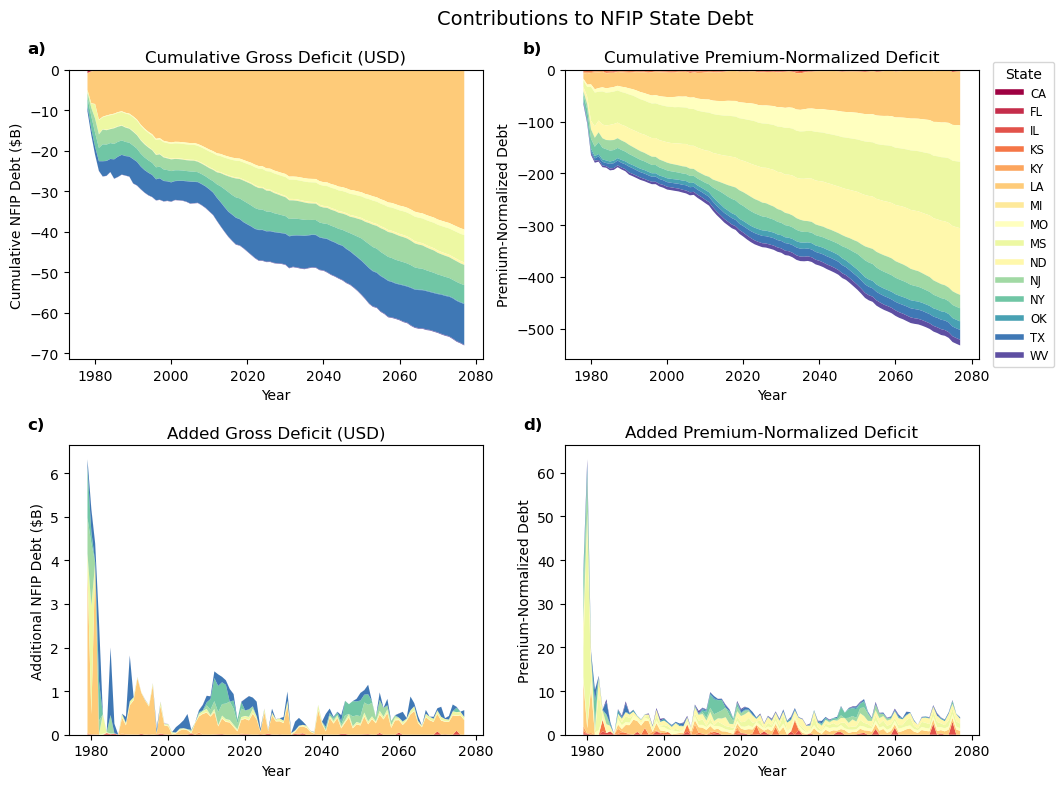

In [27]:
# Simulated structure from previous pipeline
df = pd.concat(state_balance_output, ignore_index=True)
df["State"] = df["STATEFP"].map({
    '22': 'LA', '28': 'MS', '38': 'ND', '48': 'TX', '36': 'NY', '34': 'NJ',
    '29': 'MO', '40': 'OK', '54': 'WV', '17': 'IL', '20': 'KS', '21': 'KY',
    '12': 'FL', '26': 'MI', '06': 'CA'
})

# Filter to selected states
selected_states = ['LA', 'MS', 'ND', 'TX', 'NY', 'NJ', 'MO', 'OK', 'WV', 'IL', 'KS', 'KY', 'FL', 'MI', 'CA']
df = df[df["State"].isin(selected_states)]

# Add cumulative and yearly balance tracking
df["nfip_balance"] = df.groupby(["simulation", "State"])["contribution"].cumsum()
df["yearly_debt"] = df["contribution"]  # Negative contributions = debt

# Filter to negative balance years only
neg_df = df[df["nfip_balance"] < 0]

# Pivot for plotting
pivot_df = (
    neg_df.groupby(["year", "State"])["nfip_balance"]
    .mean()
    .unstack(fill_value=0)
)

# Normalize by premium
premium_df = (
    df.groupby("State")["premium"]
    .mean()
    .replace(0, np.nan)
)
normalized_pivot_df = pivot_df.divide(premium_df, axis=1)

# Compute year-over-year added deficit
delta_neg_billion = pivot_df.diff().clip(upper=0).abs() / 1e9
pivot_df_billion = pivot_df / 1e9

# Normalize YOY added deficit
delta_norm = normalized_pivot_df.diff().clip(upper=0).abs()

# Colors and figure setup
states = sorted(pivot_df.columns)
cmap = cm.get_cmap("Spectral", len(states))
colors = {state: cmap(i) for i, state in enumerate(states)}
colors['ND'] = (1.0, 0.973, 0.676, 1.0)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Contributions to NFIP State Debt", fontsize=14)

panel_labels = ['a)', 'b)', 'c)', 'd)']
label_offset = (-0.1, 1.1)

def custom_stackplot(ax, df, title, ylabel, xlabel, label_text, label_pos):
    x = df.index
    y = [df[state].values for state in states]
    ax.stackplot(x, y, labels=states, colors=[colors[s] for s in states], linewidth=0)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(label_pos[0], label_pos[1], label_text, transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

custom_stackplot(axs[0, 0], pivot_df_billion, "Cumulative Gross Deficit (USD)", "Cumulative NFIP Debt ($B)", "Year", panel_labels[0], label_offset)
custom_stackplot(axs[0, 1], normalized_pivot_df, "Cumulative Premium-Normalized Deficit", "Premium-Normalized Debt", "Year", panel_labels[1], label_offset)
custom_stackplot(axs[1, 0], delta_neg_billion, "Added Gross Deficit (USD)", "Additional NFIP Debt ($B)", "Year", panel_labels[2], label_offset)
custom_stackplot(axs[1, 1], delta_norm, "Added Premium-Normalized Deficit", "Premium-Normalized Debt", "Year", panel_labels[3], label_offset)

# Legend
handles = [plt.Line2D([0], [0], color=colors[s], lw=4) for s in states]
axs[0, 1].legend(handles, states, loc='center left', bbox_to_anchor=(1.02, 0.5),
                 title="State", fontsize='small', title_fontsize='medium')

plt.tight_layout()
plt.subplots_adjust(right=0.82)
if save:
    plt.savefig(f"Plots/New/State_Debt_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

In [28]:
normalized_pivot_df.head()

State,CA,FL,IL,KS,KY,LA,MI,MO,MS,ND,NJ,NY,OK,TX,WV
year,,,,,,,,,,,,,,,
1978,-0.394953,-0.491159,-1.469059,-2.038174,-1.474162,-10.882965,-0.323519,-3.108853,-12.087528,-8.776798,-6.453189,-11.216508,-2.815011,-2.363505,-2.397618
1979,0.000000,-0.201625,-1.850614,-2.534137,-2.565089,-20.769551,-0.640658,-4.174932,-18.531575,-14.581511,-10.709482,-17.672466,-3.699570,-2.703344,-2.633170
1980,0.000000,0.000000,-2.115783,-1.860946,-1.785024,-21.989014,0.000000,-4.794027,-65.641358,-16.549177,-18.150685,-19.104536,-4.769303,-3.670607,-3.622933
1981,0.000000,0.000000,-1.617406,-1.101459,-2.187053,-32.302819,0.000000,-6.468393,-65.183332,-22.305660,-17.265519,-18.087998,-4.556714,-4.495274,-3.674225
1982,0.000000,0.000000,-1.541725,-0.804663,-2.182783,-30.409771,0.000000,-7.005329,-55.655842,-22.834836,-18.868844,-23.124225,-4.529518,-7.065477,-3.162412


## Benefit and Strain

In [29]:
# Sum reinsurance used and final balance per state
re_summary = (
    cluster_state_df.groupby("STATEFP")[["re_covered"]]
    .sum()
    .reset_index()
)

balance_summary = (
    final_balances_df.groupby("STATEFP")[["nfip_balance"]]
    .mean()  # or .last() if only using final year
    .reset_index()
)

premium_summary = (
    gdf_states[["STATEFP", "Total Written Premium + FPF"]]
    .rename(columns={"Total Written Premium + FPF": "premium"})
)

# Merge all together
summary_df = (
    re_summary
    .merge(balance_summary, on="STATEFP", how="outer")
    .merge(premium_summary, on="STATEFP", how="left")
)

# Drop states with zero or missing premium
summary_df = summary_df[summary_df["premium"] > 0].copy()
summary_df["premium"] = summary_df["premium"].replace(0, np.nan)

# --- Derived Metrics ---
summary_df["Norm_re"] = summary_df["re_covered"] / summary_df["premium"]
summary_df["Norm_balance"] = summary_df["nfip_balance"] / summary_df["premium"]

# System-wide benefit
total_balance = summary_df["nfip_balance"].sum()
total_premiums = summary_df["premium"].sum()
epsilon = 0.1

summary_df["Net_benefit"] = total_balance / summary_df["nfip_balance"].clip(lower=epsilon)
summary_df["Original_benefit"] = total_premiums / summary_df["premium"]
summary_df["Norm_strain"] = (summary_df["Net_benefit"] - summary_df["Original_benefit"]) / summary_df["Net_benefit"]

# Merge back to gdf_states for plotting
gdf_plot = gdf_states.merge(summary_df, on="STATEFP", how="left")

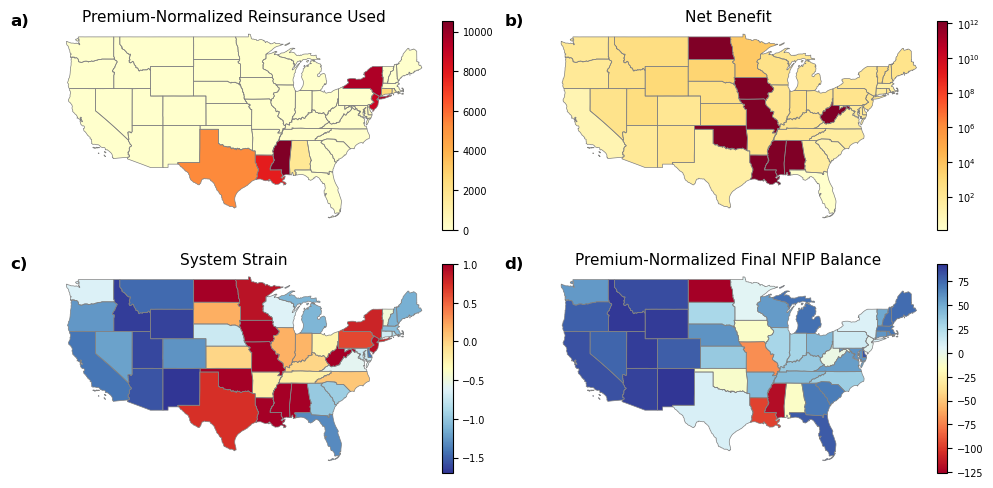

In [30]:
# Panel metadata
plot_data = [
    ("Norm_re", "Premium-Normalized Reinsurance Used", "a)", lambda v: f"{v:.1f}", "YlOrRd", None, ""),
    ("Net_benefit", "Net Benefit", "b)", lambda v: f"1e{int(np.round(np.log10(v)))}" if v > 0 else "0", "YlOrRd",
     LogNorm(vmin=gdf_plot["Net_benefit"].replace(0, np.nan).min(), vmax=gdf_plot["Net_benefit"].max()), ""),
    ("Norm_strain", "System Strain", "c)", lambda v: f"{v:.1f}", "RdYlBu_r", None, ""),
    ("Norm_balance", "Premium-Normalized Final NFIP Balance", "d)", lambda v: f"{v:.0f}", "RdYlBu", None, ""),
]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
extent = [-130, -65, 24, 50]
x_min, x_max, y_min, y_max = extent
skip_labels = {"DC", "RI", "CT", "DE", "MD", "NH"}

for i, (ax, (col, title, label, fmt_fn, cmap, norm, cbar_label)) in enumerate(zip(axs.flat, plot_data)):
    gdf_plot.plot(
        column=col, cmap=cmap, linewidth=0.1, ax=ax,
        norm=norm, legend=False
    )
    gdf_plot.boundary.plot(ax=ax, color="grey", linewidth=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("off")
    ax.set_title(title, fontsize=11)

    #if i in [2, 3]:
    """
    for idx, row in gdf_plot.iterrows():
        abbr = row["STUSPS"]
        rep_point = row.geometry.representative_point()
        x, y = rep_point.x, rep_point.y
        val = row[col]
        if abbr in skip_labels or np.isnan(val):
            continue
        ax.text(x, y, fmt_fn(val), ha='center', va='center', fontsize=6, color='black')
    """
    
    ax.text(-0.06, 1.02, label, transform=ax.transAxes, size=12, weight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm if norm else plt.Normalize(
        vmin=gdf_plot[col].min(), vmax=gdf_plot[col].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label(cbar_label, fontsize=8)
    cbar.ax.tick_params(labelsize=7)

plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/Strain_Reinsurance4_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Relative Hyperclusters

In [31]:
# Step 1: Filter to years after 1987 (10 years)
post_initial_period = balance_transition_df[balance_transition_df["year"] > 1987]

# Step 2: Count how many simulations each cluster appears in
cluster_sim_counts = (
    post_initial_period
    .groupby("top_cluster")["simulation"]
    .nunique()
)

# Step 3: Filter to only clusters that appear in at least 20 simulations
if test_case == "historic":
    frequent_clusters = cluster_sim_counts[cluster_sim_counts >= 1].index
else:
    num_thres = simulations*0.2
    frequent_clusters = cluster_sim_counts[cluster_sim_counts >= num_thres].index

# Step 4: Convert to set
events = set(frequent_clusters)

# Step 1: Define known cluster mapping
cluster_event_map = {
    511: "1978 Summer Flash Floods",
    17: "Hurricane Frederic", # 1979
    231: "1979 Midwest Floods",
    27: "1979 Easter Flood",
    393: "1979 Grand Forks Floods",
    60: "1982 Meramec Flood",
    278: "1984 May Floods",
    5115: "1984 Tulsa Memorial Day Flood",
    65: "1986 Oklahoma Floods",
    367: "1985 Election Day Floods",
    203: "Great Flood of 1993",
    218: "1994 Meramec Flood",
    342: "1995 NOLA Floods",
    157: "Hurricane Fran", # 1996
    137: "1996 Northeast Floods",
    236: "1997 Red River Flood",
    56: "1997 Ohio River Valley Flood",
    268: "1998 Townsville Floods",
    7: "Hurricane Georges", # 1998
    312: "Tropical Storm Allison", # 2001
    147: "Hurricane Isabel", # 2003
    6: "Hurricane Ivan", # 2004
    4: "Hurricane Katrina", # 2005
    153: "2006 Northeast Floods",
    8: "Hurricane Ike", # 2008
    267: "2007 TX/OK Floods",
    199: "2008 Midwest Floods",
    391: "2009 Red River Flood",
    2279: "2010 Central Iowa Floods",
    33: "2010 TN Floods",
    35: "2011 Mississippi River Floods",
    4826: "2011 Souris River Flood",
    5602: "2011 Missouri River Flood",
    91: "Hurricane Irene", # 2011
    131: "Tropical Storm Lee", # 2011
    87: "Hurricane Sandy", # 2012
    54: "2015 Ozarks Flood",
    64: "2015 TX/OK Flood and Tornadoes",
    295: "2016 Louisiana Floods",
    168: "Hurricane Matthew",
    500: "2016 West Virginia Downpour",
    49: "2017 Midwest Floods",
    327: "Hurricane Harvey", # 2017
    376: "Hurricane Florence", # 2018
    63: "2019 Arkansas River Floods",
    5587: "2019 SD Flash Floods",
    263: "2019 Midwest Floods",
    1: "Hurricane Sally", # 2020
    166: "Hurricane Ian", # 2022
    3723: "2022 St. Louis Flash Flood",
    95: "2023 Northeast Floods",
    190: "Hurricane Helene", # 2024
}

print(f'{len(events)} Imbalancing events:{events}')

20 Imbalancing events:{131.0, 4.0, 6.0, 8.0, 137.0, 267.0, 33.0, 63.0, 64.0, 199.0, 327.0, 203.0, 87.0, 4826.0, 91.0, 5602.0, 236.0, 367.0, 500.0, 5115.0}


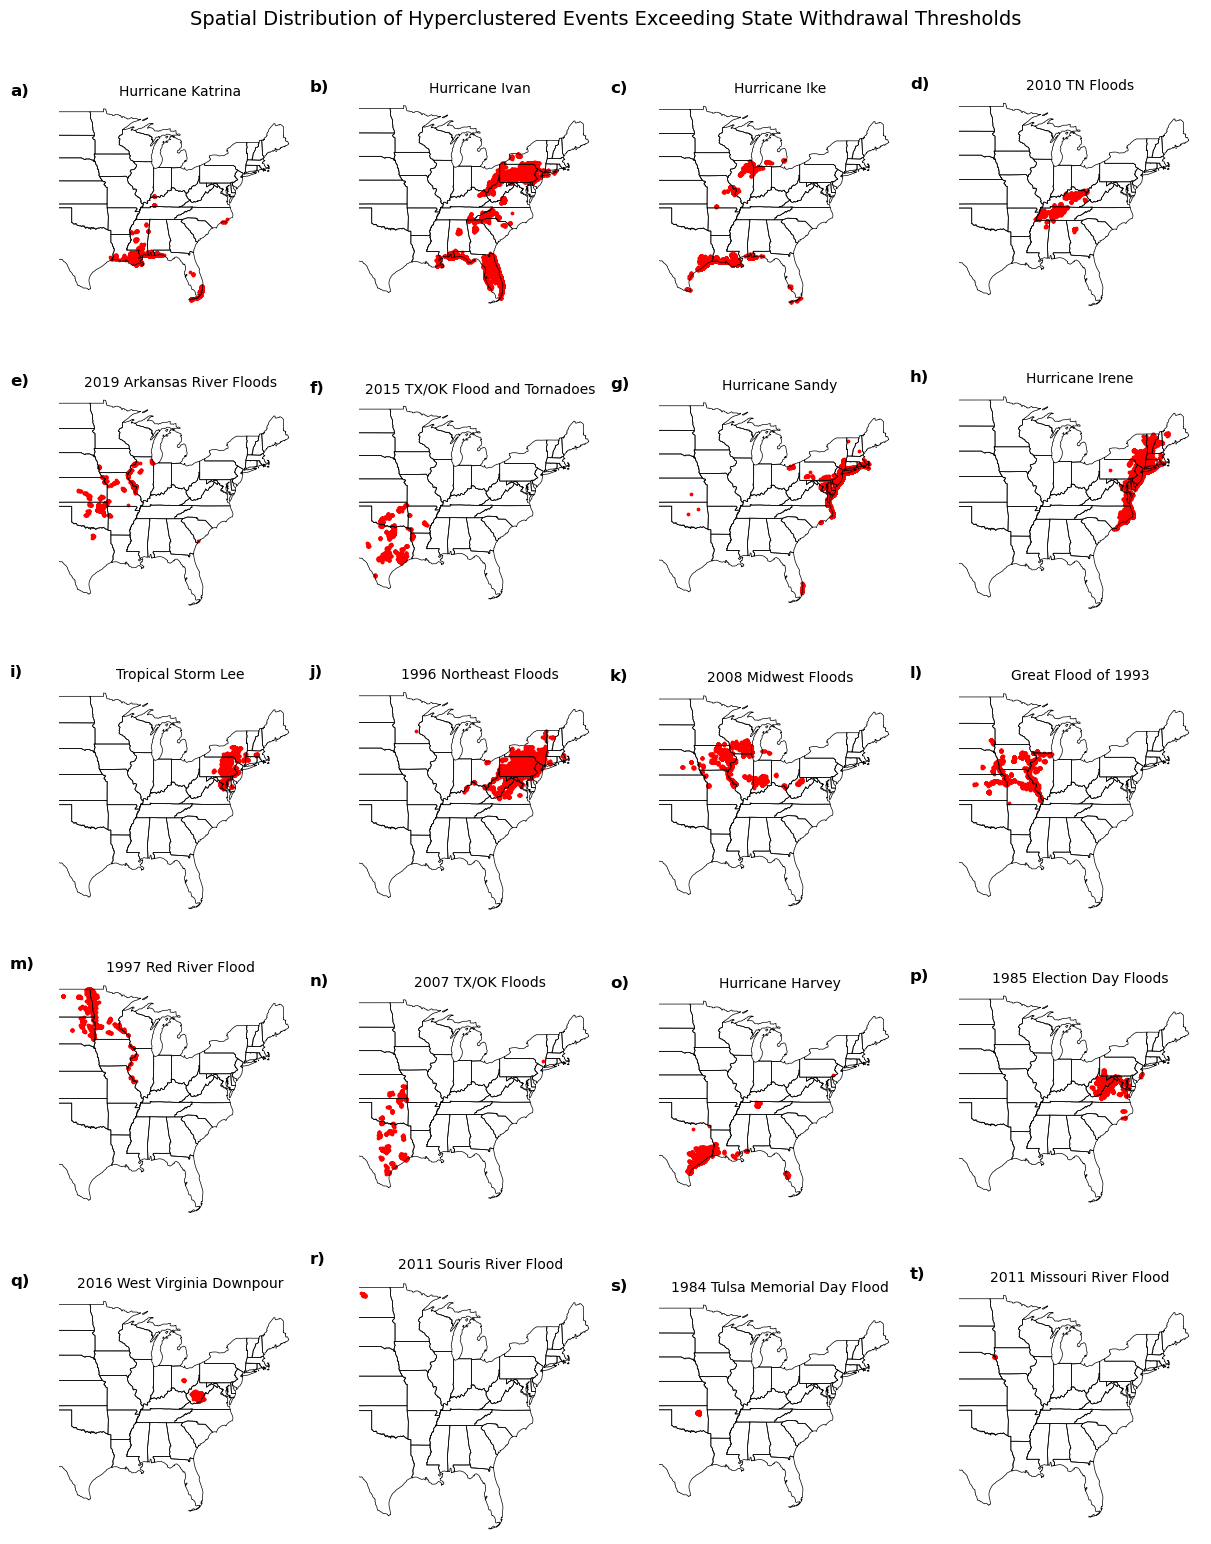

In [32]:
# Convert events to sorted list for consistent ordering
event_list = sorted(events)

# Set spatial extent for consistency
extent = [-102, -65, 24, 50]

# Adjust grid if more events are needed
n_panels = len(event_list)
ncols = 4
nrows = int(np.ceil(n_panels / ncols))

label_offset = (-0.2, 1.1)

# Prepare figure
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3 * nrows), constrained_layout=True)
axs = axs.flatten()
panel_labels = [f"{chr(97 + i)})" for i in range(len(axs))]

for i, cluster_id in enumerate(event_list):
    ax = axs[i]

    # Determine name or fallback label
    event_name = cluster_event_map.get(cluster_id, f"Cluster {cluster_id}")

    # Filter points for this cluster
    cluster_points = clustered_claims[clustered_claims[optimal_cluster] == cluster_id]

    # GeoDataFrame for plotting
    gdf_claims_all = gpd.GeoDataFrame(
        cluster_points,
        geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
        crs="EPSG:4326"
    )

    # Plot boundaries and points
    gdf_states.boundary.plot(ax=ax, color='black', linewidth=0.5)
    gdf_claims_all.plot(ax=ax, color='red', markersize=3)

    # Format plot
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(event_name, fontsize=10)
    ax.axis("off")

    # Panel label
    ax.text(label_offset[0], label_offset[1], panel_labels[i], transform=ax.transAxes,
            ha='left', va='top', fontsize=12, fontweight='bold')

# Turn off any extra axes
for j in range(len(event_list), len(axs)):
    axs[j].axis("off")

plt.suptitle("Spatial Distribution of Hyperclustered Events Exceeding State Withdrawal Thresholds", fontsize=14, y=1.03)
if save:
    plt.savefig(f"Plots/New/Clusters_Space_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()